# Dask through Jupyter Notebooks

This notebook will guide you through using Dask to analyze NanoAOD root files using a Slurm Cluster on SubMIT. This notebook utilizes a conda environment and then exports that environment in the slurm jobs. Follow the README for instructions on the conda environment. 

In [1]:
import os
import sys
import json
import time
import random
import numpy as np
from coffea import hist, processor

from dask_jobqueue import SLURMCluster
from distributed import Client
from dask.distributed import performance_report

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


We set up a coffea ABC Processor to analyze the ROOT files. Here we grab the Muon and Electron collection and add some simple selections using awkward.

In [2]:
import awkward as ak
import vector
vector.register_awkward()

class Simple_Process(processor.ProcessorABC):
    def __init__(self, isMC: int, era: int, sample: str) -> None:
        self.gensumweight = 1.0
        self.era = era
        self.isMC = isMC
        self.sample = sample

        #Set up for the histograms
        self._accumulator = processor.dict_accumulator({
            "N_Muons": hist.Hist(
                "Events",
                hist.Bin("NMuons", "Num Muons", 10, 0, 10)
            ),   
            "N_Electrons": hist.Hist(
                "Events",
                hist.Bin("NElectrons", "Num Electrons", 10, 0, 10)
            ), 
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']
        Muons = ak.zip({
              "pt": events.Muon.pt,
              "eta": events.Muon.eta,
              "phi": events.Muon.phi,
              "mass": events.Muon.mass
        }, with_name="Momentum4D") 
        cut = (events.Muon.pt > 10) & \
            (abs(events.Muon.eta) <= 2.4) & \
            (events.Muon.mediumId == 1) 
        Muons = Muons[cut]
        
        output["N_Muons"].fill(
            NMuons = ak.num(Muons),
        ) 
        
        Electrons = ak.zip({
               "pt": events.Electron.pt,
               "eta": events.Electron.eta,
               "phi": events.Electron.phi,
               "mass": events.Electron.mass
        }, with_name="Momentum4D") 
        cut_ele = (events.Electron.pt > 10) & \
            (abs(events.Electron.eta) <= 2.4) & \
            (events.Electron.mvaFall17V2Iso_WP90 == 1) 
        Electrons = Electrons[cut_ele]
        
        output["N_Electrons"].fill(
            NElectrons = ak.num(Electrons),
        ) 
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
def check_port(port):
    import socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    try:
        sock.bind(("0.0.0.0", port))
        available = True
    except:
        available = False
    sock.close()
    return available

The following section defines additional parts of the slurm Dask job. Here we source the bashrc to prepare Conda. We also pass in the x509 proxy. In order to share the proxy across the SubMIT machines you should move your proxy to your HOME directory.

In [4]:
slurm_env = [
     'export XRD_RUNFORKHANDLER=1',
     'export XRD_STREAMTIMEOUT=10',
     f'source {os.environ["HOME"]}/.bashrc',
     f'conda activate dask',
     f'export X509_USER_PROXY={os.environ["HOME"]}/x509up_u206148'
]

extra_args=[
     "--output=dask_job_output_%j.out",
     "--error=dask_job_output_%j.err",
     "--partition=submit",
     "--clusters=submit",
]

In [5]:
n_port       = 6820
w_port       = 9765
cores        = 1
processes    = 1
memory       = "5 GB"
chunksize    = 15000
maxchunks    = None

The following sets up the processor and json file. If you want to change files you can simply modify the json file

In [6]:
#Set up the processor
processor_instance = Simple_Process(isMC=1, era='2018', sample='test')

# load dataset
with open("samples.json") as f:
    sample_dict = json.load(f)
for key in sample_dict.keys():
    sample_dict[key] = sample_dict[key][:]

The next section forms the Slurm Cluster. You can set up various parameters of the cluster here.

In [7]:
if not check_port(n_port):
    raise RuntimeError("Port '{}' is occupied on this node. Try another one.".format(n_port))

import socket
cluster = SLURMCluster(
        queue='all',
        project="SUEP_Slurm",
        cores=cores,
        processes=processes,
        memory=memory,
        #retries=10,
        walltime='00:30:00',
        scheduler_options={
              'port': n_port,
              'dashboard_address': 8000,
              'host': socket.gethostname()
        },
        job_extra=extra_args,
        env_extra=slurm_env,
)

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8000 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 5435 instead
  warnings.warn(
Clear task state
  Scheduler at:     tcp://18.12.2.18:6820
  dashboard at:           18.12.2.18:5435


In [8]:
cluster.adapt(minimum=1, maximum=250)
client = Client(cluster)
print(client)

Receive client connection: Client-71e593b4-820c-11ec-ab4e-000af7bd3c78


<Client: 'tcp://18.12.2.18:6820' processes=0 threads=0, memory=0 B>


# Running the processor
Now we will run the code with a performance report. This will analyze all of the input ROOT files and will store the histograms in output. Then we can analyze the output and make plots.

In [9]:
with performance_report(filename="dask-report.html"):
    output = processor.run_uproot_job(sample_dict,
             treename='Events',
             processor_instance=processor_instance,
             executor=processor.dask_executor,
             executor_args={
                           'client': client,
                           #'skipbadfiles': skipbadfiles,
                           'schema': processor.NanoAODSchema,
                           'xrootdtimeout': 10,
                           'retries': 3,
                           },
             chunksize=chunksize,
             maxchunks=maxchunks)

Run out-of-band function 'lambda'


[                                        ] | 0% Completed |  3.1s

Register worker <WorkerState 'tcp://18.12.2.18:6306', name: SLURMCluster-0, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:6306


[###                                     ] | 7% Completed |  7.1s

Register worker <WorkerState 'tcp://18.12.2.18:7028', name: SLURMCluster-1, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:7028


[###                                     ] | 7% Completed | 10.1s

Register worker <WorkerState 'tcp://18.12.2.18:15690', name: SLURMCluster-2, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:15690


[###                                     ] | 7% Completed | 10.2s

Register worker <WorkerState 'tcp://18.12.2.18:12208', name: SLURMCluster-3, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:12208
Register worker <WorkerState 'tcp://18.12.2.18:2450', name: SLURMCluster-6, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:2450
Register worker <WorkerState 'tcp://18.12.2.18:4695', name: SLURMCluster-4, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:4695
Register worker <WorkerState 'tcp://18.12.2.18:26626', name: SLURMCluster-5, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:26626


[###############                         ] | 38% Completed | 16.1s

Retire worker names ('SLURMCluster-6', 'SLURMCluster-3', 'SLURMCluster-4', 'SLURMCluster-2')
Retire workers {<WorkerState 'tcp://18.12.2.18:2450', name: SLURMCluster-6, status: running, memory: 0, processing: 0>, <WorkerState 'tcp://18.12.2.18:15690', name: SLURMCluster-2, status: running, memory: 1, processing: 0>, <WorkerState 'tcp://18.12.2.18:12208', name: SLURMCluster-3, status: running, memory: 0, processing: 0>, <WorkerState 'tcp://18.12.2.18:4695', name: SLURMCluster-4, status: running, memory: 1, processing: 0>}
Moving 2 keys to other workers


[###############                         ] | 38% Completed | 22.5s

Closing worker tcp://18.12.2.18:2450
Remove worker <WorkerState 'tcp://18.12.2.18:2450', name: SLURMCluster-6, status: running, memory: 0, processing: 1>
Closing worker tcp://18.12.2.18:15690
Remove worker <WorkerState 'tcp://18.12.2.18:15690', name: SLURMCluster-2, status: running, memory: 1, processing: 1>
Closing worker tcp://18.12.2.18:12208
Remove worker <WorkerState 'tcp://18.12.2.18:12208', name: SLURMCluster-3, status: running, memory: 0, processing: 2>
Closing worker tcp://18.12.2.18:4695
Remove worker <WorkerState 'tcp://18.12.2.18:4695', name: SLURMCluster-4, status: running, memory: 1, processing: 2>


[########################                ] | 61% Completed | 28.0s

Register worker <WorkerState 'tcp://18.12.2.2:41489', name: SLURMCluster-8, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:41489
Register worker <WorkerState 'tcp://18.12.2.2:36340', name: SLURMCluster-7, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:36340
Register worker <WorkerState 'tcp://18.12.2.2:45503', name: SLURMCluster-6, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:45503


[########################                ] | 61% Completed | 28.1s

Retire worker names ('SLURMCluster-6', 'SLURMCluster-8')
Retire workers {<WorkerState 'tcp://18.12.2.2:45503', name: SLURMCluster-6, status: running, memory: 0, processing: 0>, <WorkerState 'tcp://18.12.2.2:41489', name: SLURMCluster-8, status: running, memory: 0, processing: 0>}
Closing worker tcp://18.12.2.2:45503
Remove worker <WorkerState 'tcp://18.12.2.2:45503', name: SLURMCluster-6, status: running, memory: 0, processing: 0>
Closing worker tcp://18.12.2.2:41489
Remove worker <WorkerState 'tcp://18.12.2.2:41489', name: SLURMCluster-8, status: running, memory: 0, processing: 0>


[##############################          ] | 76% Completed | 34.1s

Retire worker names ('SLURMCluster-5',)
Retire workers {<WorkerState 'tcp://18.12.2.18:26626', name: SLURMCluster-5, status: running, memory: 2, processing: 0>}
Moving 2 keys to other workers
Closing worker tcp://18.12.2.18:26626
Remove worker <WorkerState 'tcp://18.12.2.18:26626', name: SLURMCluster-5, status: running, memory: 2, processing: 0>


[##############################          ] | 76% Completed | 35.1s

Retire worker names ('SLURMCluster-7',)
Retire workers {<WorkerState 'tcp://18.12.2.2:36340', name: SLURMCluster-7, status: running, memory: 1, processing: 0>}
Moving 1 keys to other workers
Closing worker tcp://18.12.2.2:36340
Remove worker <WorkerState 'tcp://18.12.2.2:36340', name: SLURMCluster-7, status: running, memory: 1, processing: 0>


[#################################       ] | 84% Completed | 38.0s

Retire worker names ('SLURMCluster-1',)
Retire workers {<WorkerState 'tcp://18.12.2.18:7028', name: SLURMCluster-1, status: running, memory: 5, processing: 0>}
Moving 5 keys to other workers
Closing worker tcp://18.12.2.18:7028


[#################################       ] | 84% Completed | 38.1s

Remove worker <WorkerState 'tcp://18.12.2.18:7028', name: SLURMCluster-1, status: running, memory: 5, processing: 0>


[                                        ] | 1% Completed |  3.5s9s

Register worker <WorkerState 'tcp://18.12.2.18:12165', name: SLURMCluster-12, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:12165
Register worker <WorkerState 'tcp://18.12.2.18:24056', name: SLURMCluster-9, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:24056
Register worker <WorkerState 'tcp://18.12.2.18:15219', name: SLURMCluster-11, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:15219
Register worker <WorkerState 'tcp://18.12.2.18:19172', name: SLURMCluster-13, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:19172
Register worker <WorkerState 'tcp://18.12.2.18:2075', name: SLURMCluster-10, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:2075
Register worker <WorkerState 'tcp://18.12.2.18:3510', name: SLURMCluster-8, status: undefined, memory: 0, process

[                                        ] | 1% Completed |  6.5s

Register worker <WorkerState 'tcp://18.12.2.18:28893', name: SLURMCluster-14, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:28893


[                                        ] | 1% Completed |  9.5s

Register worker <WorkerState 'tcp://18.12.2.18:27189', name: SLURMCluster-17, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:27189


[                                        ] | 1% Completed |  9.6s

Register worker <WorkerState 'tcp://18.12.2.18:26134', name: SLURMCluster-15, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:26134


[                                        ] | 1% Completed | 10.9s

Register worker <WorkerState 'tcp://18.12.2.2:41663', name: SLURMCluster-18, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:41663
Register worker <WorkerState 'tcp://18.12.2.2:45045', name: SLURMCluster-16, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:45045


[#                                       ] | 2% Completed | 13.8s

Register worker <WorkerState 'tcp://18.12.2.2:33696', name: SLURMCluster-21, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:33696
Register worker <WorkerState 'tcp://18.12.2.2:33379', name: SLURMCluster-23, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:33379
Register worker <WorkerState 'tcp://18.12.2.2:45082', name: SLURMCluster-19, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:45082
Register worker <WorkerState 'tcp://18.12.2.2:33917', name: SLURMCluster-24, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:33917
Register worker <WorkerState 'tcp://18.12.2.2:41251', name: SLURMCluster-22, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:41251
Register worker <WorkerState 'tcp://18.12.2.2:36109', name: SLURMCluster-20, status: undefined, memory: 0, processing: 0

[#                                       ] | 2% Completed | 14.1s

Register worker <WorkerState 'tcp://18.12.2.2:39729', name: SLURMCluster-26, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:39729
Register worker <WorkerState 'tcp://18.12.2.2:40629', name: SLURMCluster-25, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:40629


[##                                      ] | 5% Completed | 18.6s

Register worker <WorkerState 'tcp://18.12.2.6:45984', name: SLURMCluster-38, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:45984
Register worker <WorkerState 'tcp://18.12.2.6:37950', name: SLURMCluster-71, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:37950
Register worker <WorkerState 'tcp://18.12.2.6:42943', name: SLURMCluster-47, status: undefined, memory: 0, processing: 0>


[##                                      ] | 5% Completed | 18.7s

Starting worker compute stream, tcp://18.12.2.6:42943
Register worker <WorkerState 'tcp://18.12.2.6:39276', name: SLURMCluster-42, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:39276
Register worker <WorkerState 'tcp://18.12.2.6:44349', name: SLURMCluster-52, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:44349
Register worker <WorkerState 'tcp://18.12.2.6:42745', name: SLURMCluster-66, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:42745
Register worker <WorkerState 'tcp://18.12.2.6:33320', name: SLURMCluster-40, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:33320
Register worker <WorkerState 'tcp://18.12.2.6:42854', name: SLURMCluster-39, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:42854
Register worker <WorkerState 'tcp://18.12.2.6:41726', name: SLURMC

[##                                      ] | 5% Completed | 19.1s

Retire worker names ('SLURMCluster-29',)


[##                                      ] | 5% Completed | 19.3s

Register worker <WorkerState 'tcp://18.12.2.7:44420', name: SLURMCluster-43, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.7:44420
Register worker <WorkerState 'tcp://18.12.2.7:42179', name: SLURMCluster-53, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.7:42179
Register worker <WorkerState 'tcp://18.12.2.7:44537', name: SLURMCluster-61, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.7:44537
Register worker <WorkerState 'tcp://18.12.2.7:45375', name: SLURMCluster-63, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.7:45375
Register worker <WorkerState 'tcp://18.12.2.7:46294', name: SLURMCluster-49, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.7:46294
Register worker <WorkerState 'tcp://18.12.2.7:40557', name: SLURMCluster-54, status: undefined, memory: 0, processing: 0

[##                                      ] | 5% Completed | 19.6s

Register worker <WorkerState 'tcp://18.12.2.5:14518', name: SLURMCluster-31, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.5:14518
Register worker <WorkerState 'tcp://18.12.2.5:12113', name: SLURMCluster-27, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.5:12113
Register worker <WorkerState 'tcp://18.12.2.5:12121', name: SLURMCluster-28, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.5:12121
Register worker <WorkerState 'tcp://18.12.2.5:15913', name: SLURMCluster-32, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.5:15913
Register worker <WorkerState 'tcp://18.12.2.5:3017', name: SLURMCluster-30, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.5:3017
Register worker <WorkerState 'tcp://18.12.2.5:18937', name: SLURMCluster-35, status: undefined, memory: 0, processing: 0>


[##                                      ] | 5% Completed | 20.2s

Register worker <WorkerState 'tcp://18.12.2.8:22555', name: SLURMCluster-57, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.8:22555
Register worker <WorkerState 'tcp://18.12.2.8:26631', name: SLURMCluster-69, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.8:26631
Register worker <WorkerState 'tcp://18.12.2.8:21678', name: SLURMCluster-73, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.8:21678
Register worker <WorkerState 'tcp://18.12.2.8:25328', name: SLURMCluster-55, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.8:25328


[##                                      ] | 6% Completed | 22.2s

Retire worker names ('SLURMCluster-74',)


[##                                      ] | 6% Completed | 23.1s

Register worker <WorkerState 'tcp://18.12.2.8:29132', name: SLURMCluster-58, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.8:29132
Register worker <WorkerState 'tcp://18.12.2.8:4400', name: SLURMCluster-65, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.8:4400
Register worker <WorkerState 'tcp://18.12.2.8:8227', name: SLURMCluster-46, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.8:8227
Register worker <WorkerState 'tcp://18.12.2.8:24121', name: SLURMCluster-59, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.8:24121
Register worker <WorkerState 'tcp://18.12.2.8:22717', name: SLURMCluster-64, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.8:22717
Retire worker names ('SLURMCluster-67',)


[##                                      ] | 6% Completed | 23.2s

Register worker <WorkerState 'tcp://18.12.2.8:9768', name: SLURMCluster-70, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.8:9768


[##                                      ] | 6% Completed | 23.8s

Register worker <WorkerState 'tcp://18.12.2.9:42401', name: SLURMCluster-68, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.9:42401
Register worker <WorkerState 'tcp://18.12.2.9:33542', name: SLURMCluster-72, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.9:33542
Register worker <WorkerState 'tcp://18.12.2.9:43699', name: SLURMCluster-60, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.9:43699
Register worker <WorkerState 'tcp://18.12.2.9:36185', name: SLURMCluster-44, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.9:36185
Register worker <WorkerState 'tcp://18.12.2.9:38895', name: SLURMCluster-62, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.9:38895
Register worker <WorkerState 'tcp://18.12.2.9:43372', name: SLURMCluster-48, status: undefined, memory: 0, processing: 0

[####                                    ] | 12% Completed | 31.2s

Retire worker names ('SLURMCluster-61',)
Retire workers {<WorkerState 'tcp://18.12.2.7:44537', name: SLURMCluster-61, status: running, memory: 2, processing: 0>}
Moving 1 keys to other workers


[#####                                   ] | 13% Completed | 32.1s

Closing worker tcp://18.12.2.7:44537
Remove worker <WorkerState 'tcp://18.12.2.7:44537', name: SLURMCluster-61, status: running, memory: 2, processing: 0>


[#####                                   ] | 13% Completed | 32.2s

Retire worker names ('SLURMCluster-17', 'SLURMCluster-52')
Retire workers {<WorkerState 'tcp://18.12.2.6:44349', name: SLURMCluster-52, status: running, memory: 2, processing: 0>, <WorkerState 'tcp://18.12.2.18:27189', name: SLURMCluster-17, status: running, memory: 2, processing: 0>}
Moving 2 keys to other workers
Closing worker tcp://18.12.2.6:44349
Remove worker <WorkerState 'tcp://18.12.2.6:44349', name: SLURMCluster-52, status: running, memory: 2, processing: 0>
Closing worker tcp://18.12.2.18:27189
Remove worker <WorkerState 'tcp://18.12.2.18:27189', name: SLURMCluster-17, status: running, memory: 2, processing: 0>


[#####                                   ] | 14% Completed | 33.1s

Retire worker names ('SLURMCluster-53',)
Retire workers {<WorkerState 'tcp://18.12.2.7:42179', name: SLURMCluster-53, status: running, memory: 2, processing: 0>}
Moving 1 keys to other workers
Closing worker tcp://18.12.2.7:42179
Remove worker <WorkerState 'tcp://18.12.2.7:42179', name: SLURMCluster-53, status: running, memory: 2, processing: 0>


[#####                                   ] | 14% Completed | 34.1s

Retire worker names ('SLURMCluster-28',)
Retire workers {<WorkerState 'tcp://18.12.2.5:12121', name: SLURMCluster-28, status: running, memory: 2, processing: 0>}
Moving 1 keys to other workers
Closing worker tcp://18.12.2.5:12121
Remove worker <WorkerState 'tcp://18.12.2.5:12121', name: SLURMCluster-28, status: running, memory: 2, processing: 0>


[######                                  ] | 16% Completed | 35.2s

Retire worker names ('SLURMCluster-0',)
Retire workers {<WorkerState 'tcp://18.12.2.18:6306', name: SLURMCluster-0, status: running, memory: 3, processing: 0>}
Moving 2 keys to other workers
Closing worker tcp://18.12.2.18:6306
Remove worker <WorkerState 'tcp://18.12.2.18:6306', name: SLURMCluster-0, status: running, memory: 3, processing: 0>


[#######                                 ] | 18% Completed | 37.1s

Retire worker names ('SLURMCluster-18',)
Retire workers {<WorkerState 'tcp://18.12.2.2:41663', name: SLURMCluster-18, status: running, memory: 2, processing: 0>}
Moving 1 keys to other workers


[#######                                 ] | 18% Completed | 37.2s

Closing worker tcp://18.12.2.2:41663
Remove worker <WorkerState 'tcp://18.12.2.2:41663', name: SLURMCluster-18, status: running, memory: 2, processing: 0>


[#######                                 ] | 19% Completed | 38.1s

Retire worker names ('SLURMCluster-12',)
Retire workers {<WorkerState 'tcp://18.12.2.18:12165', name: SLURMCluster-12, status: running, memory: 2, processing: 0>}
Moving 1 keys to other workers
Closing worker tcp://18.12.2.18:12165
Remove worker <WorkerState 'tcp://18.12.2.18:12165', name: SLURMCluster-12, status: running, memory: 2, processing: 0>


[#########                               ] | 22% Completed | 39.1s

Retire worker names ('SLURMCluster-8',)
Retire workers {<WorkerState 'tcp://18.12.2.18:3510', name: SLURMCluster-8, status: running, memory: 2, processing: 0>}
Moving 1 keys to other workers
Closing worker tcp://18.12.2.18:3510
Remove worker <WorkerState 'tcp://18.12.2.18:3510', name: SLURMCluster-8, status: running, memory: 2, processing: 0>


[#########                               ] | 24% Completed | 40.2s

Retire worker names ('SLURMCluster-11',)
Retire workers {<WorkerState 'tcp://18.12.2.18:15219', name: SLURMCluster-11, status: running, memory: 2, processing: 0>}
Moving 1 keys to other workers
Closing worker tcp://18.12.2.18:15219
Remove worker <WorkerState 'tcp://18.12.2.18:15219', name: SLURMCluster-11, status: running, memory: 2, processing: 0>


[###########                             ] | 28% Completed | 41.1s

Retire worker names ('SLURMCluster-14', 'SLURMCluster-9')
Retire workers {<WorkerState 'tcp://18.12.2.18:24056', name: SLURMCluster-9, status: running, memory: 2, processing: 0>, <WorkerState 'tcp://18.12.2.18:28893', name: SLURMCluster-14, status: running, memory: 3, processing: 0>}
Moving 3 keys to other workers


[###########                             ] | 28% Completed | 41.2s

Closing worker tcp://18.12.2.18:24056
Remove worker <WorkerState 'tcp://18.12.2.18:24056', name: SLURMCluster-9, status: running, memory: 2, processing: 0>
Closing worker tcp://18.12.2.18:28893
Remove worker <WorkerState 'tcp://18.12.2.18:28893', name: SLURMCluster-14, status: running, memory: 3, processing: 0>


[###########                             ] | 28% Completed | 42.1s

Retire worker names ('SLURMCluster-58',)
Retire workers {<WorkerState 'tcp://18.12.2.8:29132', name: SLURMCluster-58, status: running, memory: 2, processing: 0>}
Moving 1 keys to other workers
Closing worker tcp://18.12.2.8:29132
Remove worker <WorkerState 'tcp://18.12.2.8:29132', name: SLURMCluster-58, status: running, memory: 2, processing: 0>


[###########                             ] | 28% Completed | 43.1s

Retire worker names ('SLURMCluster-10', 'SLURMCluster-48')
Retire workers {<WorkerState 'tcp://18.12.2.9:43372', name: SLURMCluster-48, status: running, memory: 2, processing: 0>, <WorkerState 'tcp://18.12.2.18:2075', name: SLURMCluster-10, status: running, memory: 3, processing: 0>}
Moving 3 keys to other workers
Closing worker tcp://18.12.2.9:43372
Remove worker <WorkerState 'tcp://18.12.2.9:43372', name: SLURMCluster-48, status: running, memory: 2, processing: 0>
Closing worker tcp://18.12.2.18:2075
Remove worker <WorkerState 'tcp://18.12.2.18:2075', name: SLURMCluster-10, status: running, memory: 3, processing: 0>


[###########                             ] | 29% Completed | 44.1s

Retire worker names ('SLURMCluster-60',)
Retire workers {<WorkerState 'tcp://18.12.2.9:43699', name: SLURMCluster-60, status: running, memory: 2, processing: 0>}
Moving 1 keys to other workers
Closing worker tcp://18.12.2.9:43699
Remove worker <WorkerState 'tcp://18.12.2.9:43699', name: SLURMCluster-60, status: running, memory: 2, processing: 0>


[############                            ] | 30% Completed | 46.2s

Retire worker names ('SLURMCluster-44',)
Retire workers {<WorkerState 'tcp://18.12.2.9:36185', name: SLURMCluster-44, status: running, memory: 2, processing: 0>}
Moving 1 keys to other workers
Closing worker tcp://18.12.2.9:36185
Remove worker <WorkerState 'tcp://18.12.2.9:36185', name: SLURMCluster-44, status: running, memory: 2, processing: 0>


[############                            ] | 31% Completed | 48.1s

Retire worker names ('SLURMCluster-20',)
Retire workers {<WorkerState 'tcp://18.12.2.2:36109', name: SLURMCluster-20, status: running, memory: 2, processing: 0>}
Moving 1 keys to other workers


[############                            ] | 31% Completed | 48.2s

Closing worker tcp://18.12.2.2:36109
Remove worker <WorkerState 'tcp://18.12.2.2:36109', name: SLURMCluster-20, status: running, memory: 2, processing: 0>


[#############                           ] | 33% Completed | 49.1s

Retire worker names ('SLURMCluster-16',)
Retire workers {<WorkerState 'tcp://18.12.2.2:45045', name: SLURMCluster-16, status: running, memory: 4, processing: 0>}
Moving 3 keys to other workers


[#############                           ] | 33% Completed | 49.2s

Closing worker tcp://18.12.2.2:45045
Remove worker <WorkerState 'tcp://18.12.2.2:45045', name: SLURMCluster-16, status: running, memory: 4, processing: 0>


[##############                          ] | 36% Completed | 51.1s

Retire worker names ('SLURMCluster-34',)
Retire workers {<WorkerState 'tcp://18.12.2.5:31927', name: SLURMCluster-34, status: running, memory: 2, processing: 0>}
Moving 1 keys to other workers
Closing worker tcp://18.12.2.5:31927
Remove worker <WorkerState 'tcp://18.12.2.5:31927', name: SLURMCluster-34, status: running, memory: 2, processing: 0>


[##############                          ] | 36% Completed | 52.1s

Retire worker names ('SLURMCluster-19',)
Retire workers {<WorkerState 'tcp://18.12.2.2:45082', name: SLURMCluster-19, status: running, memory: 2, processing: 0>}
Moving 1 keys to other workers
Closing worker tcp://18.12.2.2:45082
Remove worker <WorkerState 'tcp://18.12.2.2:45082', name: SLURMCluster-19, status: running, memory: 2, processing: 0>


[##################                      ] | 45% Completed | 55.1s

Retire worker names ('SLURMCluster-36', 'SLURMCluster-41')
Retire workers {<WorkerState 'tcp://18.12.2.5:27823', name: SLURMCluster-36, status: running, memory: 3, processing: 0>, <WorkerState 'tcp://18.12.2.6:39194', name: SLURMCluster-41, status: running, memory: 2, processing: 0>}
Moving 3 keys to other workers


[##################                      ] | 45% Completed | 55.2s

Closing worker tcp://18.12.2.5:27823
Remove worker <WorkerState 'tcp://18.12.2.5:27823', name: SLURMCluster-36, status: running, memory: 3, processing: 0>
Closing worker tcp://18.12.2.6:39194
Remove worker <WorkerState 'tcp://18.12.2.6:39194', name: SLURMCluster-41, status: running, memory: 2, processing: 0>


[##################                      ] | 46% Completed | 56.1s

Retire worker names ('SLURMCluster-43', 'SLURMCluster-62', 'SLURMCluster-46')
Retire workers {<WorkerState 'tcp://18.12.2.8:8227', name: SLURMCluster-46, status: running, memory: 2, processing: 0>, <WorkerState 'tcp://18.12.2.7:44420', name: SLURMCluster-43, status: running, memory: 2, processing: 0>, <WorkerState 'tcp://18.12.2.9:38895', name: SLURMCluster-62, status: running, memory: 5, processing: 0>}
Moving 6 keys to other workers
Closing worker tcp://18.12.2.8:8227
Remove worker <WorkerState 'tcp://18.12.2.8:8227', name: SLURMCluster-46, status: running, memory: 2, processing: 0>
Closing worker tcp://18.12.2.7:44420
Remove worker <WorkerState 'tcp://18.12.2.7:44420', name: SLURMCluster-43, status: running, memory: 2, processing: 0>
Closing worker tcp://18.12.2.9:38895
Remove worker <WorkerState 'tcp://18.12.2.9:38895', name: SLURMCluster-62, status: running, memory: 5, processing: 0>


[###################                     ] | 49% Completed | 57.1s

Retire worker names ('SLURMCluster-50', 'SLURMCluster-49', 'SLURMCluster-70')
Retire workers {<WorkerState 'tcp://18.12.2.7:41593', name: SLURMCluster-50, status: running, memory: 3, processing: 0>, <WorkerState 'tcp://18.12.2.7:46294', name: SLURMCluster-49, status: running, memory: 2, processing: 0>, <WorkerState 'tcp://18.12.2.8:9768', name: SLURMCluster-70, status: running, memory: 2, processing: 0>}
Moving 4 keys to other workers
Closing worker tcp://18.12.2.7:41593
Remove worker <WorkerState 'tcp://18.12.2.7:41593', name: SLURMCluster-50, status: running, memory: 3, processing: 0>
Closing worker tcp://18.12.2.7:46294
Remove worker <WorkerState 'tcp://18.12.2.7:46294', name: SLURMCluster-49, status: running, memory: 2, processing: 0>
Closing worker tcp://18.12.2.8:9768
Remove worker <WorkerState 'tcp://18.12.2.8:9768', name: SLURMCluster-70, status: running, memory: 2, processing: 0>


[####################                    ] | 52% Completed | 58.2s

Retire worker names ('SLURMCluster-59',)
Retire workers {<WorkerState 'tcp://18.12.2.8:24121', name: SLURMCluster-59, status: running, memory: 2, processing: 0>}
Moving 1 keys to other workers
Closing worker tcp://18.12.2.8:24121
Remove worker <WorkerState 'tcp://18.12.2.8:24121', name: SLURMCluster-59, status: running, memory: 2, processing: 0>


[####################                    ] | 52% Completed | 59.2s

Retire worker names ('SLURMCluster-45', 'SLURMCluster-38')
Retire workers {<WorkerState 'tcp://18.12.2.6:45984', name: SLURMCluster-38, status: running, memory: 2, processing: 0>, <WorkerState 'tcp://18.12.2.7:36861', name: SLURMCluster-45, status: running, memory: 3, processing: 0>}
Moving 3 keys to other workers
Closing worker tcp://18.12.2.6:45984
Remove worker <WorkerState 'tcp://18.12.2.6:45984', name: SLURMCluster-38, status: running, memory: 2, processing: 0>
Closing worker tcp://18.12.2.7:36861
Remove worker <WorkerState 'tcp://18.12.2.7:36861', name: SLURMCluster-45, status: running, memory: 3, processing: 0>


[####################                    ] | 52% Completed |  1min  0.1s

Retire worker names ('SLURMCluster-54', 'SLURMCluster-27')
Retire workers {<WorkerState 'tcp://18.12.2.7:40557', name: SLURMCluster-54, status: running, memory: 4, processing: 0>, <WorkerState 'tcp://18.12.2.5:12113', name: SLURMCluster-27, status: running, memory: 5, processing: 0>}
Moving 7 keys to other workers
Closing worker tcp://18.12.2.7:40557
Remove worker <WorkerState 'tcp://18.12.2.7:40557', name: SLURMCluster-54, status: running, memory: 4, processing: 0>
Closing worker tcp://18.12.2.5:12113
Remove worker <WorkerState 'tcp://18.12.2.5:12113', name: SLURMCluster-27, status: running, memory: 5, processing: 0>


[########################                ] | 60% Completed |  1min  4.1s

Retire worker names ('SLURMCluster-30', 'SLURMCluster-25')
Retire workers {<WorkerState 'tcp://18.12.2.5:3017', name: SLURMCluster-30, status: running, memory: 3, processing: 0>, <WorkerState 'tcp://18.12.2.2:40629', name: SLURMCluster-25, status: running, memory: 6, processing: 0>}
Moving 7 keys to other workers
Closing worker tcp://18.12.2.5:3017
Remove worker <WorkerState 'tcp://18.12.2.5:3017', name: SLURMCluster-30, status: running, memory: 3, processing: 0>
Closing worker tcp://18.12.2.2:40629
Remove worker <WorkerState 'tcp://18.12.2.2:40629', name: SLURMCluster-25, status: running, memory: 6, processing: 0>


[########################                ] | 60% Completed |  1min  5.1s

Retire worker names ('SLURMCluster-21', 'SLURMCluster-42')
Retire workers {<WorkerState 'tcp://18.12.2.2:33696', name: SLURMCluster-21, status: running, memory: 3, processing: 0>, <WorkerState 'tcp://18.12.2.6:39276', name: SLURMCluster-42, status: running, memory: 6, processing: 0>}
Moving 7 keys to other workers
Closing worker tcp://18.12.2.2:33696
Remove worker <WorkerState 'tcp://18.12.2.2:33696', name: SLURMCluster-21, status: running, memory: 3, processing: 0>
Closing worker tcp://18.12.2.6:39276
Remove worker <WorkerState 'tcp://18.12.2.6:39276', name: SLURMCluster-42, status: running, memory: 6, processing: 0>


[########################                ] | 61% Completed |  1min  6.1s

Retire worker names ('SLURMCluster-47',)
Retire workers {<WorkerState 'tcp://18.12.2.6:42943', name: SLURMCluster-47, status: running, memory: 3, processing: 0>}
Moving 2 keys to other workers
Closing worker tcp://18.12.2.6:42943
Remove worker <WorkerState 'tcp://18.12.2.6:42943', name: SLURMCluster-47, status: running, memory: 3, processing: 0>


[#########################               ] | 62% Completed |  1min  8.2s

Retire worker names ('SLURMCluster-13', 'SLURMCluster-40')
Retire workers {<WorkerState 'tcp://18.12.2.18:19172', name: SLURMCluster-13, status: running, memory: 5, processing: 0>, <WorkerState 'tcp://18.12.2.6:33320', name: SLURMCluster-40, status: running, memory: 3, processing: 0>}
Moving 6 keys to other workers
Closing worker tcp://18.12.2.18:19172
Remove worker <WorkerState 'tcp://18.12.2.18:19172', name: SLURMCluster-13, status: running, memory: 5, processing: 0>
Closing worker tcp://18.12.2.6:33320
Remove worker <WorkerState 'tcp://18.12.2.6:33320', name: SLURMCluster-40, status: running, memory: 3, processing: 0>


[#########################               ] | 62% Completed |  1min 10.1s

Retire worker names ('SLURMCluster-69',)
Retire workers {<WorkerState 'tcp://18.12.2.8:26631', name: SLURMCluster-69, status: running, memory: 3, processing: 0>}
Moving 2 keys to other workers
Closing worker tcp://18.12.2.8:26631
Remove worker <WorkerState 'tcp://18.12.2.8:26631', name: SLURMCluster-69, status: running, memory: 3, processing: 0>


[############################            ] | 70% Completed |  1min 14.2s

Retire worker names ('SLURMCluster-32',)
Retire workers {<WorkerState 'tcp://18.12.2.5:15913', name: SLURMCluster-32, status: running, memory: 4, processing: 0>}
Moving 3 keys to other workers
Closing worker tcp://18.12.2.5:15913
Remove worker <WorkerState 'tcp://18.12.2.5:15913', name: SLURMCluster-32, status: running, memory: 4, processing: 0>


[#############################           ] | 73% Completed |  1min 15.1s

Retire worker names ('SLURMCluster-31',)
Retire workers {<WorkerState 'tcp://18.12.2.5:14518', name: SLURMCluster-31, status: running, memory: 4, processing: 0>}
Moving 3 keys to other workers


[#############################           ] | 73% Completed |  1min 15.2s

Closing worker tcp://18.12.2.5:14518
Remove worker <WorkerState 'tcp://18.12.2.5:14518', name: SLURMCluster-31, status: running, memory: 4, processing: 0>


[#############################           ] | 73% Completed |  1min 16.1s

Retire worker names ('SLURMCluster-35', 'SLURMCluster-15', 'SLURMCluster-73')
Retire workers {<WorkerState 'tcp://18.12.2.18:26134', name: SLURMCluster-15, status: running, memory: 4, processing: 0>, <WorkerState 'tcp://18.12.2.8:21678', name: SLURMCluster-73, status: running, memory: 5, processing: 0>, <WorkerState 'tcp://18.12.2.5:18937', name: SLURMCluster-35, status: running, memory: 6, processing: 0>}
Moving 12 keys to other workers


[#############################           ] | 73% Completed |  1min 16.6s

Closing worker tcp://18.12.2.18:26134
Remove worker <WorkerState 'tcp://18.12.2.18:26134', name: SLURMCluster-15, status: running, memory: 4, processing: 0>
Closing worker tcp://18.12.2.8:21678
Remove worker <WorkerState 'tcp://18.12.2.8:21678', name: SLURMCluster-73, status: running, memory: 5, processing: 0>
Closing worker tcp://18.12.2.5:18937
Remove worker <WorkerState 'tcp://18.12.2.5:18937', name: SLURMCluster-35, status: running, memory: 6, processing: 0>


[#############################           ] | 73% Completed |  1min 17.1s

Retire worker names ('SLURMCluster-51',)
Retire workers {<WorkerState 'tcp://18.12.2.7:35776', name: SLURMCluster-51, status: running, memory: 3, processing: 0>}
Moving 2 keys to other workers


[#############################           ] | 73% Completed |  1min 17.2s

Closing worker tcp://18.12.2.7:35776
Remove worker <WorkerState 'tcp://18.12.2.7:35776', name: SLURMCluster-51, status: running, memory: 3, processing: 0>


[##############################          ] | 76% Completed |  1min 19.1s

Retire worker names ('SLURMCluster-23',)
Retire workers {<WorkerState 'tcp://18.12.2.2:33379', name: SLURMCluster-23, status: running, memory: 4, processing: 0>}
Moving 3 keys to other workers
Closing worker tcp://18.12.2.2:33379
Remove worker <WorkerState 'tcp://18.12.2.2:33379', name: SLURMCluster-23, status: running, memory: 4, processing: 0>


[###############################         ] | 78% Completed |  1min 20.1s

Retire worker names ('SLURMCluster-66',)
Retire workers {<WorkerState 'tcp://18.12.2.6:42745', name: SLURMCluster-66, status: running, memory: 5, processing: 0>}
Moving 4 keys to other workers
Closing worker tcp://18.12.2.6:42745
Remove worker <WorkerState 'tcp://18.12.2.6:42745', name: SLURMCluster-66, status: running, memory: 5, processing: 0>


[################################        ] | 80% Completed |  1min 21.2s

Retire worker names ('SLURMCluster-26',)
Retire workers {<WorkerState 'tcp://18.12.2.2:39729', name: SLURMCluster-26, status: running, memory: 4, processing: 0>}
Moving 3 keys to other workers
Closing worker tcp://18.12.2.2:39729
Remove worker <WorkerState 'tcp://18.12.2.2:39729', name: SLURMCluster-26, status: running, memory: 4, processing: 0>


[################################        ] | 80% Completed |  1min 22.2s

Retire worker names ('SLURMCluster-33', 'SLURMCluster-72')
Retire workers {<WorkerState 'tcp://18.12.2.9:33542', name: SLURMCluster-72, status: running, memory: 6, processing: 0>, <WorkerState 'tcp://18.12.2.5:18931', name: SLURMCluster-33, status: running, memory: 5, processing: 0>}
Moving 9 keys to other workers
Closing worker tcp://18.12.2.9:33542
Remove worker <WorkerState 'tcp://18.12.2.9:33542', name: SLURMCluster-72, status: running, memory: 6, processing: 0>
Closing worker tcp://18.12.2.5:18931
Remove worker <WorkerState 'tcp://18.12.2.5:18931', name: SLURMCluster-33, status: running, memory: 5, processing: 0>


[################################        ] | 80% Completed |  1min 23.1s

Retire worker names ('SLURMCluster-68',)
Retire workers {<WorkerState 'tcp://18.12.2.9:42401', name: SLURMCluster-68, status: running, memory: 5, processing: 0>}
Moving 4 keys to other workers
Closing worker tcp://18.12.2.9:42401
Remove worker <WorkerState 'tcp://18.12.2.9:42401', name: SLURMCluster-68, status: running, memory: 5, processing: 0>


[##################################      ] | 86% Completed |  1min 26.2s

Retire worker names ('SLURMCluster-63', 'SLURMCluster-37')
Retire workers {<WorkerState 'tcp://18.12.2.7:45375', name: SLURMCluster-63, status: running, memory: 4, processing: 0>, <WorkerState 'tcp://18.12.2.6:41726', name: SLURMCluster-37, status: running, memory: 7, processing: 0>}
Moving 9 keys to other workers
Closing worker tcp://18.12.2.7:45375
Remove worker <WorkerState 'tcp://18.12.2.7:45375', name: SLURMCluster-63, status: running, memory: 4, processing: 0>
Closing worker tcp://18.12.2.6:41726
Remove worker <WorkerState 'tcp://18.12.2.6:41726', name: SLURMCluster-37, status: running, memory: 7, processing: 0>


[##################################      ] | 86% Completed |  1min 27.1s

Retire worker names ('SLURMCluster-39',)
Retire workers {<WorkerState 'tcp://18.12.2.6:42854', name: SLURMCluster-39, status: running, memory: 5, processing: 0>}
Moving 4 keys to other workers


[##################################      ] | 86% Completed |  1min 27.2s

Closing worker tcp://18.12.2.6:42854
Remove worker <WorkerState 'tcp://18.12.2.6:42854', name: SLURMCluster-39, status: running, memory: 5, processing: 0>


[##################################      ] | 86% Completed |  1min 28.1s

Retire worker names ('SLURMCluster-65',)
Retire workers {<WorkerState 'tcp://18.12.2.8:4400', name: SLURMCluster-65, status: running, memory: 8, processing: 0>}
Moving 7 keys to other workers
Closing worker tcp://18.12.2.8:4400
Remove worker <WorkerState 'tcp://18.12.2.8:4400', name: SLURMCluster-65, status: running, memory: 8, processing: 0>


[####################################    ] | 90% Completed |  1min 32.1s

Retire worker names ('SLURMCluster-57',)
Retire workers {<WorkerState 'tcp://18.12.2.8:22555', name: SLURMCluster-57, status: running, memory: 8, processing: 0>}
Moving 7 keys to other workers


[####################################    ] | 90% Completed |  1min 32.2s

Closing worker tcp://18.12.2.8:22555
Remove worker <WorkerState 'tcp://18.12.2.8:22555', name: SLURMCluster-57, status: running, memory: 8, processing: 0>


[####################################    ] | 90% Completed |  1min 33.1s

Retire worker names ('SLURMCluster-64',)
Retire workers {<WorkerState 'tcp://18.12.2.8:22717', name: SLURMCluster-64, status: running, memory: 9, processing: 0>}
Moving 8 keys to other workers
Closing worker tcp://18.12.2.8:22717
Remove worker <WorkerState 'tcp://18.12.2.8:22717', name: SLURMCluster-64, status: running, memory: 9, processing: 0>


[####################################    ] | 90% Completed |  1min 34.1s

Retire worker names ('SLURMCluster-71',)
Retire workers {<WorkerState 'tcp://18.12.2.6:37950', name: SLURMCluster-71, status: running, memory: 13, processing: 0>}
Moving 12 keys to other workers
Closing worker tcp://18.12.2.6:37950
Remove worker <WorkerState 'tcp://18.12.2.6:37950', name: SLURMCluster-71, status: running, memory: 13, processing: 0>


[####################################    ] | 92% Completed |  1min 37.2s

Retire worker names ('SLURMCluster-22',)
Retire workers {<WorkerState 'tcp://18.12.2.2:41251', name: SLURMCluster-22, status: running, memory: 10, processing: 0>}
Moving 9 keys to other workers
Closing worker tcp://18.12.2.2:41251
Remove worker <WorkerState 'tcp://18.12.2.2:41251', name: SLURMCluster-22, status: running, memory: 10, processing: 0>


Retire worker names ('SLURMCluster-55',)
Retire workers {<WorkerState 'tcp://18.12.2.8:25328', name: SLURMCluster-55, status: running, memory: 0, processing: 0>}
Closing worker tcp://18.12.2.8:25328
Remove worker <WorkerState 'tcp://18.12.2.8:25328', name: SLURMCluster-55, status: running, memory: 0, processing: 0>


In [10]:
output['N_Muons']

<Hist (NMuons) instance at 0x7f1a8c7ddcd0>

Retire worker names ('SLURMCluster-56',)
Retire workers {<WorkerState 'tcp://18.12.2.7:42948', name: SLURMCluster-56, status: running, memory: 0, processing: 0>}
Closing worker tcp://18.12.2.7:42948
Remove worker <WorkerState 'tcp://18.12.2.7:42948', name: SLURMCluster-56, status: running, memory: 0, processing: 0>


/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


<AxesSubplot:xlabel='Num Muons', ylabel='Events'>

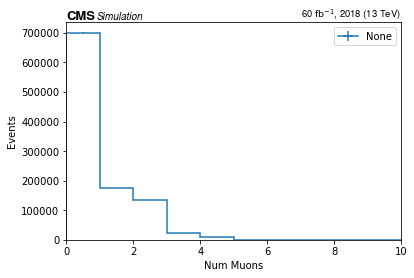

In [11]:
import mplhep as hep
#import hist
from coffea import hist

# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False, lumi=60, year=2018)

import matplotlib.pyplot as plt
hist.plot1d(output['N_Muons'])

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


<AxesSubplot:xlabel='Num Electrons', ylabel='Events'>

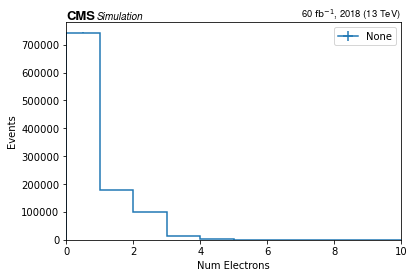

In [13]:
hep.cms.label(data=False, lumi=60, year=2018)
hist.plot1d(output['N_Electrons'])